This notebook uses Amazon (baby products) ratings data to predict ratings on other products.  The data is very, very sparse however (less than 0.1%) so you shouldn't really expect a good model.

In [1]:
# https://github.com/ipython/ipykernel/issues/111
# Create logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create STDERR handler
import sys
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(asctime)-15s : %(levelname)s : %(message)s') # - %(name)s %(clientip)s %(user)-8s
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

In [3]:
import os
import pandas as pd
datasets_path = '/home/fred/data'
small_ratings_file = os.path.join(datasets_path, 'amazon', 'ratings_Baby.csv')
df = pd.read_csv(small_ratings_file, sep=',', header=None, names=['user', 'item', 'rating', 'timestamp'])
print('{}\n{}\n{}'.format(df.dtypes, df.columns, df.shape)) # 915,446 total ratings

user          object
item          object
rating       float64
timestamp      int64
dtype: object
Index(['user', 'item', 'rating', 'timestamp'], dtype='object')
(915446, 4)


In [4]:
from tf_amazon import sparse_pivot
from tf_amazon import vae
from tf_amazon import dataset
from tf_amazon import train

2017-02-24 07:57:23,557 : INFO : tf_amazon imported
2017-02-24 07:57:23,570 : INFO : Loading train.py


In [12]:
reload(sparse_pivot)

# including both training and test data in the same matrix so that all users and
# items are accounted for in the resulting DataSet
n_training = 50000 # training takes 6 minutes for 30 epochs with 50k and 20k
n_validation = 20000
n_test = 0
trmat, vamat, temat = sparse_pivot.f(df[0 : n_training + n_validation + n_test],
                                     'user', 'item', 'rating', n_validation, n_test)

# scale down to [0,1], though note that 0 indicates missing value in csr_matrix, this is what was causing
# the cost to go to NaN at times, self.x_reconstr_mean would end up with a value of 1.0 which would cause
# tf.log(1e-10 + 1 - self.x_reconstr_mean) to be -inf
trmat = trmat * 0.2
vamat = vamat * 0.2
temat = temat * 0.2

# number of *unique* users and items
n_users = trmat.shape[0]
n_items = trmat.shape[1] # scipy.sparse.csr_matrix
print(n_users) # TODO: shouldn't there be fewer given overlap (or perhaps no overlap in first 50?)
pct_nonzero = n_training * 100 / trmat.shape[0] / trmat.shape[1]
print('shape={}; n_nonzero=[{}, {}, {}]; pct_nonzero={:.3f}%'.format(trmat.shape, len(trmat.nonzero()[0]),
                                                len(vamat.nonzero()[0]), len(temat.nonzero()[0]), pct_nonzero))
#print(trmat.todense())

58940
shape=(58940, 1332); n_nonzero=[50000, 20000, 0]; pct_nonzero=0.064%


#### TODO:
1. need to sample evenly from the 5 recommendation levels
  * or just weight predictions in the loss function inversely proportional to their occurrence probability
2. probably also need to exclude users with only 1 rating during training as:
  * they don't contain any relevant useful information in the way of the relationship between ratings of a single user
  * and, as such, they bias the computed error upwards

In [13]:
reload(vae)
reload(dataset)
reload(train)

trdata = dataset.DataSet(trmat)
vadata = dataset.DataSet(vamat)

netarch = dict(
         n_input=trmat.shape[1], # number of items (e.g. 258 items vs. 9617 users)
         n_hidden_recog_1=60, # 1st layer encoder neurons
         n_hidden_recog_2=40, # 2nd layer encoder neurons
         n_z=20,              # dimensionality of latent space
         n_hidden_gener_1=40, # 1st layer decoder neurons
         n_hidden_gener_2=60) # 2nd layer decoder neurons

untrained_vae = vae.VariationalAutoencoder(netarch,
                                           min_rating=0.2,
                                           use_rmse=False,
                                           rdist=None)

batch_size = int(min(100, n_users/10))
print('batch_size = {}'.format(batch_size))
trained_vae = train.train(untrained_vae, trdata, vadata, display_step=5, training_epochs=30, batch_size=batch_size)

2017-02-24 07:58:56,425 : INFO : Loading train.py
/home/fred/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


batch_size = 100


2017-02-24 07:59:11,579 : INFO : Epoch: 001 cost=0.672 vacost=0.791 rmse=0.2662 varmse=0.4302
2017-02-24 07:59:11,632 : INFO :                     [0.475, 0.326, nan, 0.132, 0.225] avg=nan stdev=nan
2017-02-24 07:59:24,540 : INFO : Epoch: 002 cost=0.399 vacost=0.783 rmse=0.2552 varmse=0.4264
2017-02-24 07:59:24,540 : INFO :                     [0.487, 0.340, nan, 0.118, 0.200] avg=nan stdev=nan
2017-02-24 07:59:37,249 : INFO : Epoch: 003 cost=0.397 vacost=0.776 rmse=0.2541 varmse=0.4227
2017-02-24 07:59:37,250 : INFO :                     [0.488, 0.338, nan, 0.117, 0.198] avg=nan stdev=nan
2017-02-24 07:59:50,236 : INFO : Epoch: 004 cost=0.397 vacost=0.771 rmse=0.2537 varmse=0.4201
2017-02-24 07:59:50,237 : INFO :                     [0.486, 0.337, 0.200, 0.117, 0.197] avg=0.267 stdev=0.130
2017-02-24 08:00:03,223 : INFO : Epoch: 005 cost=0.396 vacost=0.766 rmse=0.2535 varmse=0.4177
2017-02-24 08:00:03,223 : INFO :                     [0.487, 0.338, 0.201, 0.115, 0.197] avg=0.268 stdev

#### Question: How really useful are ratings anyway?  The original ratings idea was based around sentiment, that it was a more fundamental building block than a Tweet.  But how much does someone really use their ratings on Netflix--occasionally at best.  On the other hand search is very useful!

poly: 0.2051 x + 0.6209; uniqpoly: 0.1326 x + 0.6417


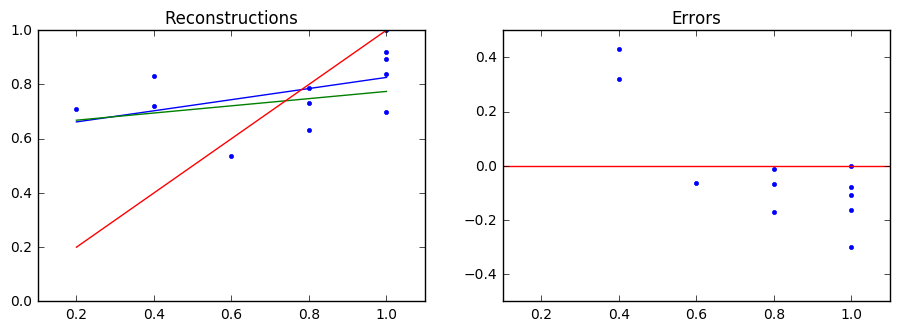

In [18]:
x_sample = trdata.next_batch(20).todense()
x_mask = np.greater(x_sample, 0.1)
x_reconstruct = trained_vae.reconstruct(x_sample)
x_errors = x_reconstruct - x_sample
x_reduceddim = trained_vae.transform(x_sample) # note that this doesn't sample z's, it only returns z_mean
x_loss = trained_vae.loss(x_sample, x_reconstruct)

fig, ax = plt.subplots(1, 2, figsize=(11, 3.5))
xs = np.asarray(x_sample[x_mask]).flatten()
ys = np.asarray(x_reconstruct[x_mask]).reshape(-1)
ax[0].plot(xs, ys, 'b.')

uniqxs = np.unique(xs)
uniqys = [np.mean(ys[np.where(xs == x)]) for x in uniqxs]

# the coefficient of this polynomial might be worth maximizing as it shows that the model is producing
# a good separation between low and high ratings and not just fitting a constant to the mode of ratings
poly = np.poly1d(np.polyfit(xs, ys, 1))
uniqpoly = np.poly1d(np.polyfit(uniqxs, uniqys, 1)) # polynomial over the averages for each x value
print('poly: {}; uniqpoly: {}'.format(str(poly)[2:], str(uniqpoly)[2:]))

ax[0].set_title('Reconstructions')
ax[0].plot(uniqxs, poly(uniqxs))
ax[0].plot(uniqxs, uniqpoly(uniqxs))
ax[0].plot(uniqxs, uniqxs)
ax[0].set_xlim(0.1, 1.1); ax[0].set_ylim(0, 1)

ax[1].set_title('Errors')
ax[1].plot(xs, np.asarray(x_errors[x_mask]).reshape(-1), 'b.')
ax[1].plot([0.1, 1.1], [0, 0], 'r')
ax[1].set_xlim(0.1, 1.1); ax[1].set_ylim(-0.5, 0.5);

In [7]:
x_sample = trdata.next_batch(1).todense()
x_reconstruct = np.multiply(trained_vae.reconstruct(x_sample), np.greater(x_sample, 0.1))
x_reduceddim = trained_vae.transform(x_sample) # note that this doesn't sample z's, it only returns z_mean
x_loss = trained_vae.loss(x_sample, x_reconstruct)
print('x = {}'.format(x_sample))
print('reconstructed = {}'.format(x_reconstruct))
print('reduceddim = {}'.format(x_reduceddim))
print('loss = {}'.format(x_loss))

x = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
reconstructed = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [8]:
x_sample = np.ones((1, n_items)) * 0.2
x_reconstruct = np.multiply(trained_vae.reconstruct(x_sample), np.greater(x_sample, 0.1))
x_reduceddim = trained_vae.transform(x_sample)
x_loss = trained_vae.loss(x_sample, x_reconstruct)
print('x = {}'.format(x_sample))
print('reconstructed = {}'.format(x_reconstruct))
print('reduceddim = {}'.format(x_reduceddim))
print('loss = {}'.format(x_loss)) # this should be very big b/c the input 'x' is very unlikely given its distribution

x = [[ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
   0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.

In [9]:
# shouldn't change from previous cell (i.e. b/c no additional sampling has occurred)
trained_vae.loss(x_sample, x_reconstruct)

(1.7288885, 0.034525335)